#### TOC
1. Anomalies in Data, and cleaning action & explaination. 15 pts
2. Pairwise Corralation Table and explaition. 10 pts
3. Average records stockID vs Day, 25 pts
    - a. autocorrelation, 10 pts
    - b. measure the distance, 5 pts
    - c. clustering algorithm, 10 pts
4. Closing trajectory of stocks on each day highly correlated, 25 pts
   - a. Make three plots, 10 pts
   - b. permutation test to determine the statistical confidence, 15 pts
      p-value
5. Best prediction model, any approaches, 25 pts
6. submit model on Kaggle, 0 pts

#### Start
- Copy this notebook.
  In Google Colab use `File -> Save a Copy in Drive`.
- Use the "Text" blocks to provide explanations wherever you find them necessary.
- Highlight your answers inside these text fields to ensure that we don't miss it
while grading your HW.

#### Setup

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and
uploading it to your drive), you can skip this section.

In [ ]:
## First mount your drive before running analysis code
from google.colab import drive
drive.mount('/content/drive')

## Create a folder for the this HW and change to that dir
%cd /content/drive/MyDrive/CSE519/hw3


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CSE519/hw3


In [ ]:
## packages
!pip install -q kaggle
!pip install -q pandas
!pip install -q scikit-learn
!pip install -q numpy
!pip install -q Matplotlib
!pip install -q seaborn
!pip install -q tabulate
!pip install -q kneed
!pip install -q xgboost


In [ ]:
## Upload the file by clicking on the browse
from google.colab import files
files.upload()

## Create a new API token under "Account" in the kaggle webpage and download the json file

{}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c optiver-trading-at-the-close
!unzip optiver-trading-at-the-close.zip
!ls

optiver-trading-at-the-close.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  optiver-trading-at-the-close.zip
replace example_test_files/revealed_targets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: cse519_hw3_shah_aayushnilesh_115647307.ipynb  optiver2023
example_test_files			      optiver-trading-at-the-close.zip
kaggle					      public_timeseries_testing_util.py
kaggle.json				      train.csv


#### Q1: Anomalies and Cleaning, 15 pts


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp
from tabulate import tabulate
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random

col_names = [
  "stock_id",
  "date_id",
  "seconds_in_bucket",
  "imbalance_size",
  "imbalance_buy_sell_flag",
  "reference_price",
  "matched_size",
  "far_price",
  "near_price",
  "bid_price",
  "bid_size",
  "ask_price",
  "ask_size",
  "wap",
  "target",
  "time_id",
  "row_id"
]
dtypes = {
  "stock_id": np.int,
  "date_id":np.int,
  "seconds_in_bucket":np.int,
  "imbalance_size":np.float32,
  "imbalance_buy_sell_flag":np.int,
  "reference_price":np.float32,
  "matched_size":np.float32,
  "far_price":np.float32,
  "near_price":np.float32,
  "bid_price":np.float32,
  "bid_size":np.float32,
  "ask_price":np.float32,
  "ask_size":np.float32,
  "wap":np.float32,
  "target":np.float32,
  "time_id":np.int,
  "row_id": "string",
}
csv = pd.read_csv("train.csv")


<ipython-input-115-a1dc57f09faf>:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "stock_id": np.int,
<ipython-input-115-a1dc57f09faf>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details

Note for the TA:

I have labeled each cell with the format Q 'question_number' cell 'number' at the start of each cell so that my explanation is easier to follow. Example Q1 Cell 1, etc.

References:
<ul>
<li> https://www.geeksforgeeks.org/working-with-missing-data-in-pandas/#:~:text=In%20order%20to%20fill%20null,in%20datasets%20of%20a%20DataFrame
<li> https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/#:~:text=StandardScaler%20follows%20Standard%20Normal%20Distribution,negative%20values%20in%20the%20dataset
<li> https://www.kaggle.com/competitions/optiver-trading-at-the-close/diliscussion/444516
<li> https://en.wikipedia.org/wiki/K-means_clustering#:~:text=k%2Dmeans%20clustering%20is%20a,a%20prototype%20of%20the%20cluster
<li>https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/#:~:text=The%20elbow%20method%20is%20a,cluster%20and%20the%20cluster%20centroid
<li>https://www.scribbr.com/statistics/t-test/#:~:text=A%20t%20test%20is%20a,are%20different%20from%20one%20another.
<li>https://towardsdatascience.com/how-to-use-permutation-tests-bacc79f45749
<li> https://www.learndatasci.com/glossary/hierarchical-clustering/#:~:text=Hierarchical%20clustering%20is%20a%20popular,hierarchical%20tree%20called%20a%20dendrogram
<li> https://machinelearningmastery.com/xgboost-for-regression/
<l1> https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
<li>
https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series

<h1>Q1</h1>

<h3>Steps followed:</h3>

<ol>
<li> Removed <b>220</b> rows with null values. <b>Reason</b>:
  <ul>
    <li> As we can see in the following Q1 cell 1 and Q1 cell 2, <b>there are 220 records</b> with "imabalance_size" as null. These records have <b>various other fields</b> that are null. Hence, Removing these fields <b>won't cause any significant loss of information</b> due to several null values in the same record.
  </ul>
<li> Didn't remove potential outliers from the remaining records. <b>Reason</b>:
  <ul>
    <li> Due to <b>lack of domain knowledge</b>, I'm unsure whether the points that seem to be outliers are acutally outliers. Probably discussing this with a domain expert might help me understand the data better. Hence, I have not removed the outliers. <br>
    <b>Note:</b> Posisble extreme outlier points can be visually seen in the output where there are multiple points that can be consider more than 1.5*IQR away from the last whisker of the box.<br>
    Please find the output of box plots in Q1 Cell 4
  </ul>
<li> Imputed values of near_price and far_price. I used Mean values to impute near_price and Median values to impute far_values <b>Reason</b>:
  <ul>
    <li> As seen in Q1 Cell 5, the mean value of "near_value" approximately lies on the median, I have assumed that it follows a normal distribution and I can use mean values to impute the missing values<br>
    We can see that the far_price values vary in very small scale and there are values that are big as well. Hence, <b>using log scale</b> will give better visualization. We can see that the <b>data is skewed</b> where there are a lot of values with small far_price. In this cause, because of skewed data structure, I have used median which is <b>robust to potential outliers</b>.
  </ul>
<li> Scaled the numeric columns (which include imbalance_size, reference_price, matched_size, far_price, near_price, bid_price, bid_size, ask_price, ask_size wap) using <b>Min-Max Scalar. Reason:</b>
  <ul>
    <li><b>Why is scaling necessary?</b> While generating new features in the upcoming questions, it is important to no let the absolute maginute of features cloud the effectiveness of that parameter, hence scaling is necessary. Also smaller values can prove to computationally efficient.
    <li><b>Why Standard Scaling?</b> In the Q1 Cell 7, we can see that there are around 5 features that have a distribution similar to Gaussian Distribution. In such cases, Standard scaling or z-score normalization is helpful. Hence, I decided to use standard scaling.
    <li><b>Why Standard Scalar for all numeric columns?</b> Initially, my approach was that I will apply Standard Scalar to those columns that are Gaussian and then apply Min-Max Scaling. But I wasn't sure whether 2 different scaling techniques should be applied to different columns in the same dataset. Hence, I'm applying Min-Max Scalar to all the columns
</ol>



In [ ]:
#Q1 Cell 1

for column in csv.columns:
    null_values = csv[column].isnull().sum()
    print(f'Column "{column}" has {null_values} null values.')

Column "stock_id" has 0 null values.
Column "date_id" has 0 null values.
Column "seconds_in_bucket" has 0 null values.
Column "imbalance_size" has 220 null values.
Column "imbalance_buy_sell_flag" has 0 null values.
Column "reference_price" has 220 null values.
Column "matched_size" has 220 null values.
Column "far_price" has 2894342 null values.
Column "near_price" has 2857180 null values.
Column "bid_price" has 220 null values.
Column "bid_size" has 0 null values.
Column "ask_price" has 220 null values.
Column "ask_size" has 0 null values.
Column "wap" has 220 null values.
Column "target" has 88 null values.
Column "time_id" has 0 null values.
Column "row_id" has 0 null values.


In [ ]:
#Q1 Cell 2

rows_with_null_imbalance = csv[csv['imbalance_size'].isnull()]
print(len(rows_with_null_imbalance))
for column in rows_with_null_imbalance.columns:
    null_values = rows_with_null_imbalance[column].isnull().sum()
    print(f'Column "{column}" has {null_values} null values.')

220
Column "stock_id" has 0 null values.
Column "date_id" has 0 null values.
Column "seconds_in_bucket" has 0 null values.
Column "imbalance_size" has 220 null values.
Column "imbalance_buy_sell_flag" has 0 null values.
Column "reference_price" has 220 null values.
Column "matched_size" has 220 null values.
Column "far_price" has 220 null values.
Column "near_price" has 220 null values.
Column "bid_price" has 220 null values.
Column "bid_size" has 0 null values.
Column "ask_price" has 220 null values.
Column "ask_size" has 0 null values.
Column "wap" has 220 null values.
Column "target" has 88 null values.
Column "time_id" has 0 null values.
Column "row_id" has 0 null values.


In [ ]:
#Q1 Cell 3

csv = csv.dropna(subset=['imbalance_size'])
for column in csv.columns:
    null_values = csv[column].isnull().sum()
    print(f'Column "{column}" has {null_values} null values.')

Column "stock_id" has 0 null values.
Column "date_id" has 0 null values.
Column "seconds_in_bucket" has 0 null values.
Column "imbalance_size" has 0 null values.
Column "imbalance_buy_sell_flag" has 0 null values.
Column "reference_price" has 0 null values.
Column "matched_size" has 0 null values.
Column "far_price" has 2894122 null values.
Column "near_price" has 2856960 null values.
Column "bid_price" has 0 null values.
Column "bid_size" has 0 null values.
Column "ask_price" has 0 null values.
Column "ask_size" has 0 null values.
Column "wap" has 0 null values.
Column "target" has 0 null values.
Column "time_id" has 0 null values.
Column "row_id" has 0 null values.


In [ ]:
print(csv.columns)

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')


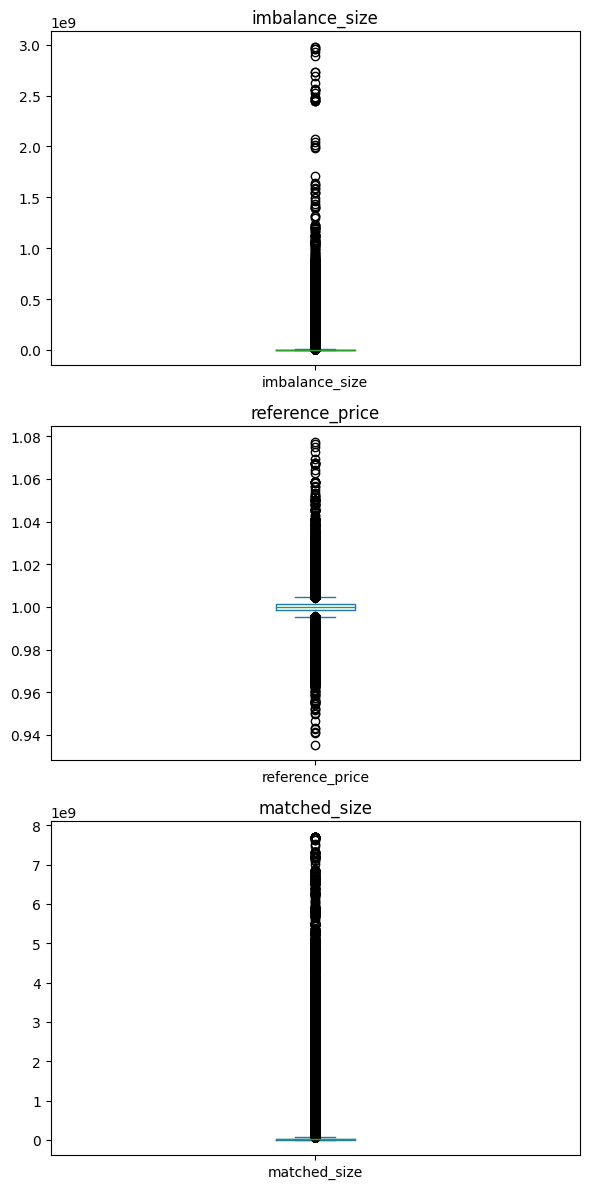

In [ ]:
#Q1 Cell 4
#Trying to visualize the distribution of data and finding potential outliers

columns_to_plot = ['imbalance_size', 'reference_price', 'matched_size']
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(6, 12))

for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    csv[column].plot(kind='box', vert=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

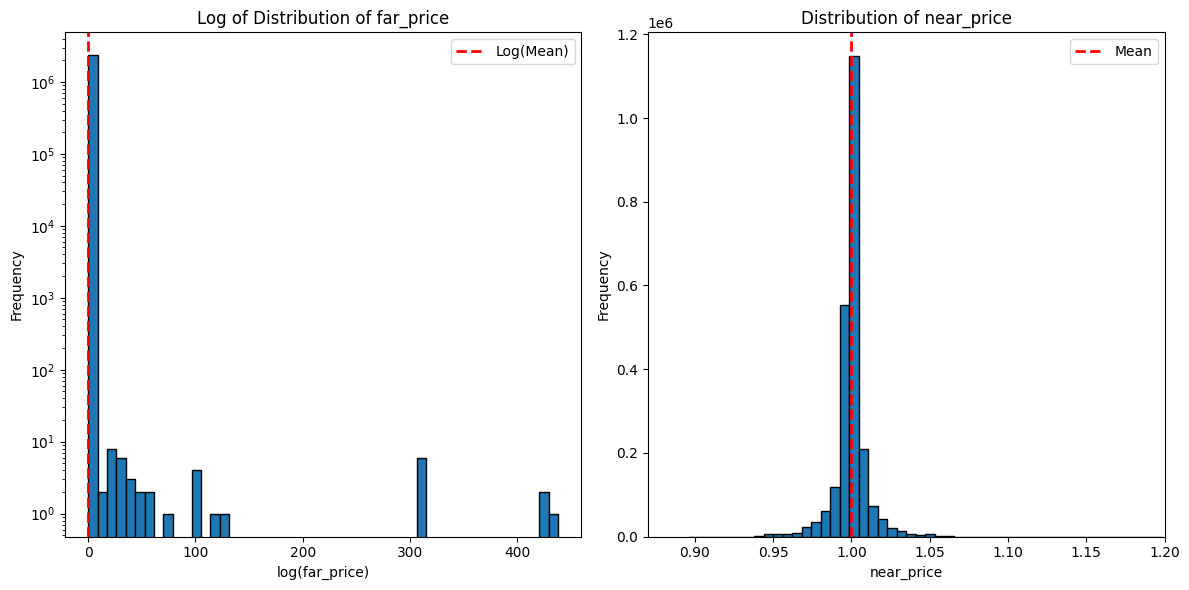

Summary statistics for far_price:
count    2.343638e+06
mean     1.001713e+00
std      7.214705e-01
min      7.700000e-05
25%      9.963320e-01
50%      9.998830e-01
75%      1.003318e+00
max      4.379531e+02
Name: far_price, dtype: float64

Summary statistics for near_price:
count    2.343638e+06
mean     9.996339e-01
std      1.011072e-02
min      8.954110e-01
25%      9.971520e-01
50%      9.998830e-01
75%      1.002518e+00
max      1.198614e+00
Name: near_price, dtype: float64


In [ ]:
#Q1 Cell 5
#Trying to figure out which value should be used for imputation

import pandas as pd
import matplotlib.pyplot as plt

filtered_data = csv.dropna(subset=['far_price', 'near_price'])

far_price_stats = filtered_data['far_price'].describe()
near_price_stats = filtered_data['near_price'].describe()

# Calculate the means
far_price_mean = np.log(far_price_stats['mean'])
near_price_mean = near_price_stats['mean']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(filtered_data['far_price'], bins=50, edgecolor='k', log=True)
plt.axvline(far_price_mean, color='red', linestyle='dashed', linewidth=2, label='Log(Mean)')
plt.title('Log of Distribution of far_price')
plt.xlabel('log(far_price)')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(filtered_data['near_price'], bins=50, edgecolor='k')
plt.axvline(near_price_mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.title('Distribution of near_price')
plt.xlabel('near_price')
plt.ylabel('Frequency')
plt.xlim(0.87,1.2)
plt.legend()

plt.tight_layout()
plt.show()

print("Summary statistics for far_price:")
print(far_price_stats)

print("\nSummary statistics for near_price:")
print(near_price_stats)

In [ ]:
#Q1 Cell 6
#Imputing Null values

median_far_price = csv['far_price'].median()
csv['far_price'].fillna(median_far_price, inplace=True)

mean_near_price = csv['near_price'].mean()
csv['near_price'].fillna(mean_near_price, inplace=True)

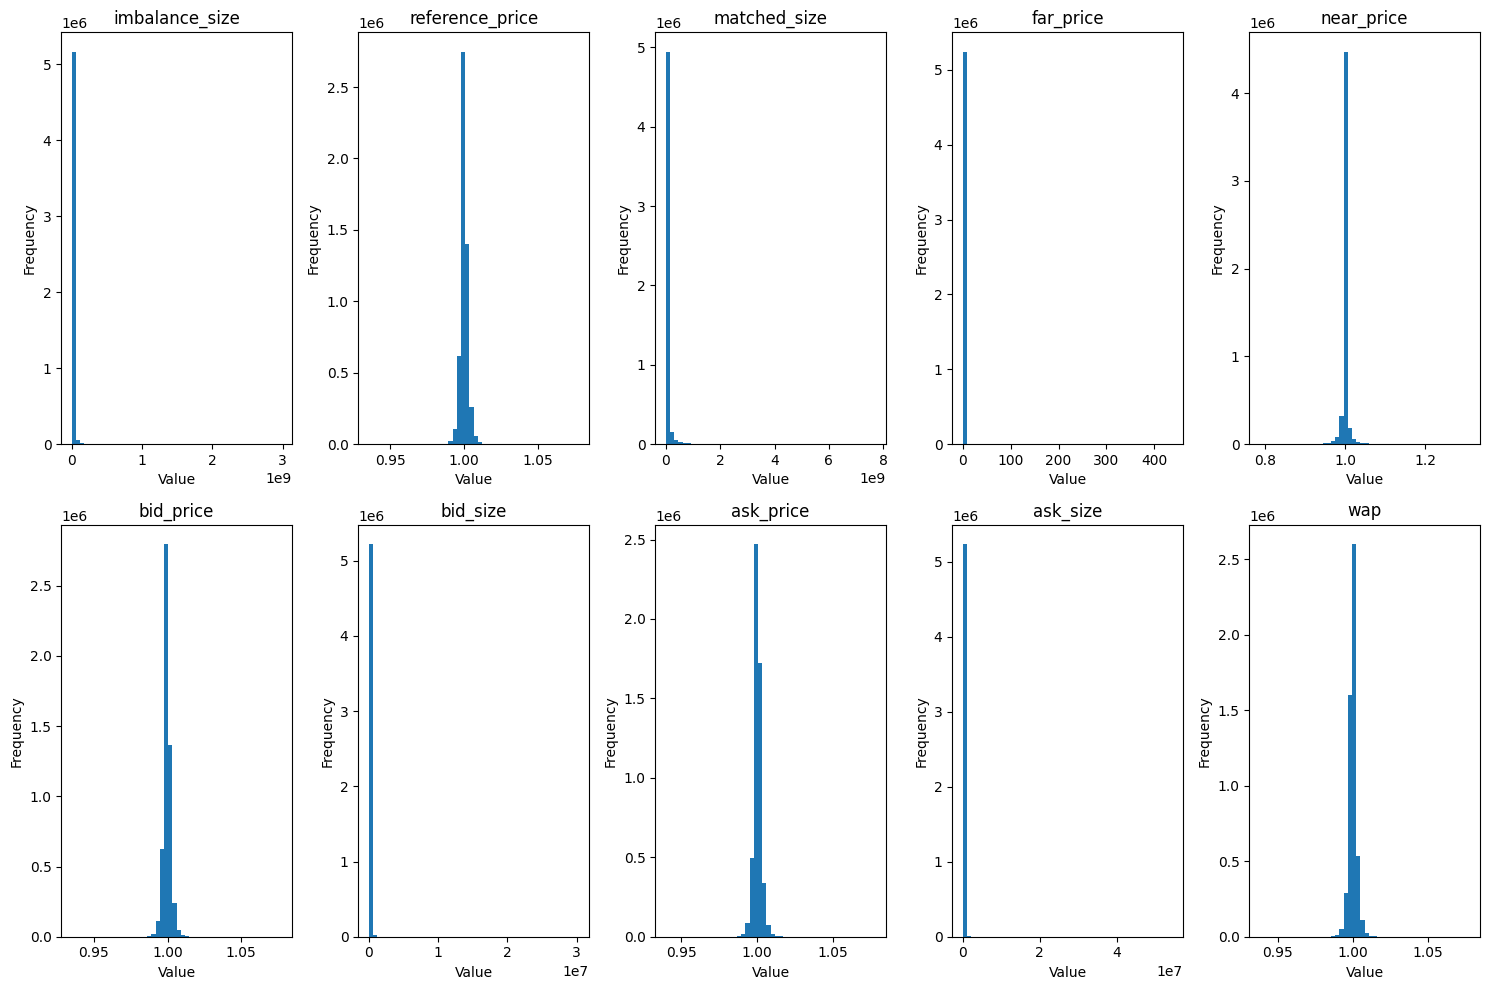

In [ ]:
#Q1 Cell 7
cols_toplot = ['imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']

num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()
for i, column in enumerate(cols_toplot):
    ax = axes[i]
    ax.hist(csv[column], bins=50)
    ax.set_title(column)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
#Q1 Cell 8

scaler = StandardScaler()
csv[cols_toplot] = scaler.fit_transform(csv[cols_toplot])

#### Q2: Pairwise Corralation Table and Explaition. 10 pts


Note for the TA: Please refer Q2 Cell 1 for the code

<ol>
<li>Bid Price and Reference Price - Correlation = 0.98:<br>
This shows that there is a strong correlation between bid price and reference price. This can be viewed in 2 ways:
  <ol>
    <li> How bid price influences reference price: Bid price shows that market sentiment or the buyer sentiment. If at a reference price, there are too many buyers(buyers' bid price is higher than reference price), it might push the reference price up showing the positive correlation.
    <li> How reference price influences bid price: Reference price can act as benchmark of what the price the price of a stock can be roughly. Based on this, the buyer sentiment develops, hence such a strong and positive correlation.
  </ol>
<li>Bid Price and Ask Price: Correlation = 0.97: <br>
It is very natural to think that if there is a high bid price, then there is high demand and consequently, there is a high ask price. Conversly, if there is a low ask price, then obviously the buyers will be happy that they can get a stock for cheaper price and hence they may reduce their bid price for a particular stock
<li> Bid Price and WAP. Correlation = 0.99: <br>
The formula of WAP is given as $$\frac{Bid Price * Ask Size + Ask Price * Bid Size}{Bid Size + Ask Size}$$
As WAP is directly proportional to Bid Price, it is natural that they will show a strong postitive correlation.
<li> Ask Price and reference Price: Correlation = 0.99:<br>
The reasoning for this can be similar to why Bid Price and Reference Price are correlated. If there sellers consensually decide that a particular stock should be priced high, then naturally the reference price will go up showing postitive correaltion. Conversely, reference price can be set using ask price as a benchmark (similar to bid price) again showing postitive strong correlation.
<li>Ask Price and WAP. Correlation = 0.99:<br>
As seen in (3), from the formula of WAP, WAP is directly proportional to Ask Price. Hence, a strong positive correlation is expected.
<li>WAP and reference price. Correlation = 0.99: <br>
As seen ealier, reference price Very strongly positively correlated with both the ask price(3) and the bid price(1). Since WAP incorporates for Ask Price and Bid Price, in the formula as seen in (4), we can expect that WAP shows a strong positive correlation with Reference Price
<li> Matched Size and Imbalance Size. Correlation = 0.51:<br>
They show a moderate correlation. This can be expected becuase it can represent the demand in the market. If there is a high matched size, is shows that there are a lot of people willing to buy. This MAY imply there are a lot of transaction that have not been settled and hence accounted for in the imbalance size.
<li> Date_id and Time_id. Correlation = 1:<br>
This is expected because given data is in serial format. And as the date increases, the time is also going to increase.

<ipython-input-125-a17d41e6be83>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = csv[csv.columns].corr()


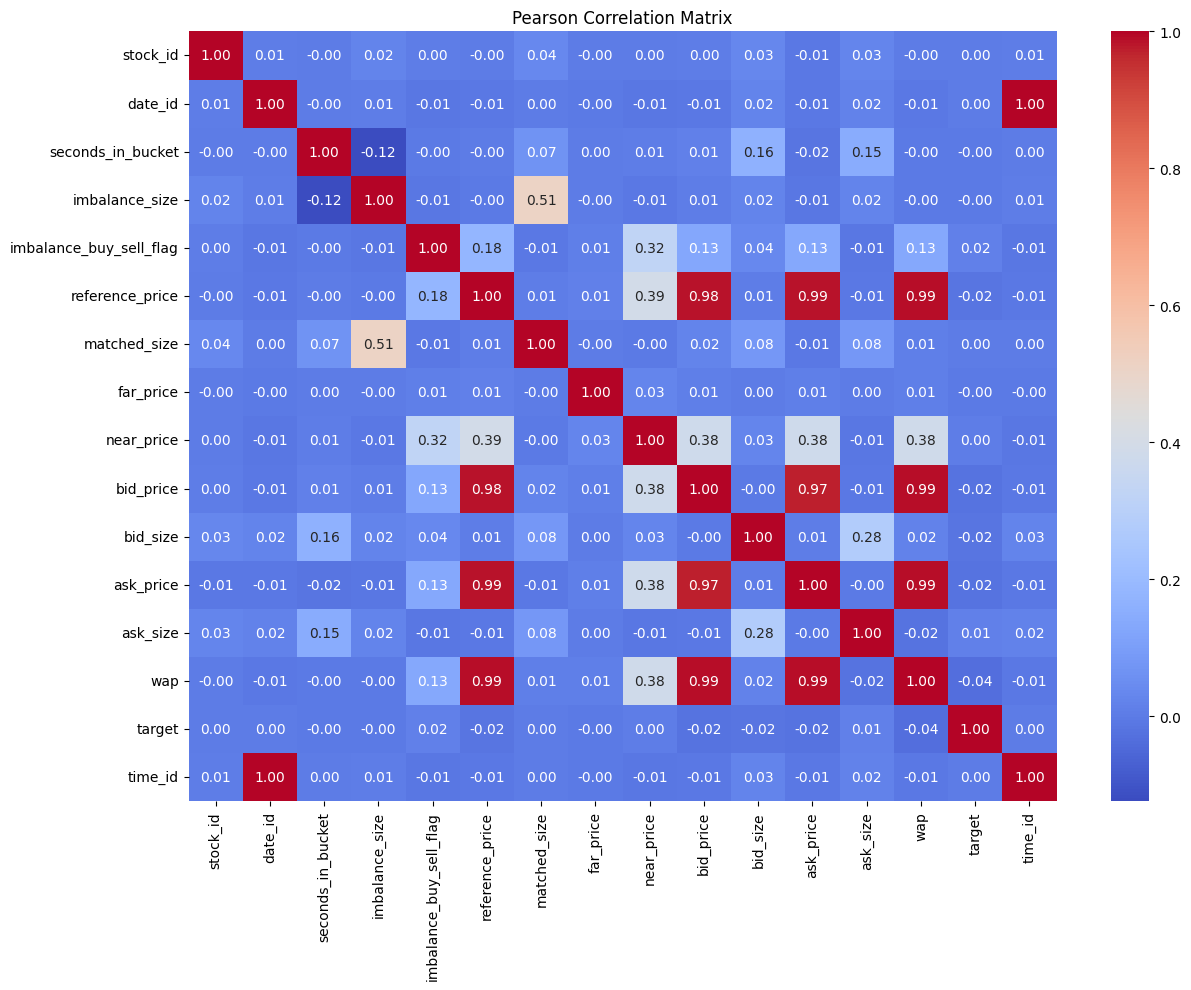

In [ ]:
#Q2 Cell 1
import seaborn as sns
correlation_matrix = csv[csv.columns].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Matrix")
plt.show()

#### Q3: Average records stockID vs Day, 25 pts
distance function between entries
- a. autocorrelation, 10 pts
- b. measure the distance, 5 pts
- c. clustering algorithm, 10 pts



<h3>My interpretation of the performance of a stock:</h3><ul>
<li>The stock should have an overall upward trajectory of price. <b>Why?</b><br>
  Upward trajectory of the data shows that buyer sentiment is positive and more people are likely to buy that stock.
<li>High trade volume of the stock. <b>Why?</b><br>
  More volume indicates that the stock has been traded between a lot of buyers and sellers. This indicates the demand of the stock. If the demand is more, then the stock should perform better.
<li>Imbalance Size at the end of the day (With Sign).<b>Why?</b><br>
  At the end of the day, if the imbalance is huge and positive, it signifies that the number of buyers are more and sellers are less. This will mostly push the value of the stock upwards for better matching size.
</ul>

<h3>How did I calculate these parameters?<h3>
<ol><li> <b>Trajectory of the price</b>: Difference between WAP of a stock at the end of the auction period and at the start of the auction period in the same day. This is because in question (2), we found out that there is a strong correlation between reference_price and WAP. Also, WAP incorporates the ask_price, bid_price, ask_size and bid_size.
<li> <b>Volume of trade</b>: Average value of (bid_size + ask_size) in a day.
<li> <b>Imbalance-end</b>: Simply use the last imbalance value of a stock available in the day of a stock
</ol>
<h3>Final statistic used</h3>
Weighted average of the above 3 features. here, I'm using equal weights as I'm unaware about the actual weights that are optimal. However, I'm using a scaled version of each feature so that one feature doesn't dominate the final statistic. <br>

The columns 'last_imbalance', 'average_size' and 'trajecotry' are used to calculate the final statistic 'performance'


In [ ]:
#Q3 cell 1
#Calculating the performance statistic

df = csv.copy()
imbalance_result = df.groupby(['date_id', 'stock_id']).apply(lambda x: (x['imbalance_size'] * x['imbalance_buy_sell_flag']).iloc[-1]).reset_index(name='last_imbalance')
df['total_size'] = df['ask_size'] + df['bid_size']
size_result = df.groupby(['date_id', 'stock_id'])['total_size'].mean().reset_index(name='average_size')
min_max_result = df.groupby(['date_id', 'stock_id'])['total_size'].agg(['min', 'max']).reset_index()
df_extra_features = imbalance_result.merge(size_result, on=['date_id', 'stock_id']).merge(min_max_result, on=['date_id', 'stock_id'])
df_extra_features['trajectory'] = df_extra_features['max'] - df_extra_features['min']

scale_columns = ['trajectory', 'last_imbalance','average_size']
min_val = df_extra_features[scale_columns].min()
max_val = df_extra_features[scale_columns].max()
scaled_df = (df_extra_features[scale_columns] - min_val) / (max_val - min_val)
scaled_average = scaled_df.mean(axis=1)
df_extra_features['performance'] = scaled_average

print(df_extra_features)

       date_id  stock_id  last_imbalance  average_size       min        max  \
0            0         0       -0.234371     -0.287916 -0.814133   0.698542   
1            0         1        0.274083     -0.599234 -0.859555   0.328965   
2            0         2       -0.000000     -0.322868 -0.856227   1.312290   
3            0         3       -0.159319     -0.319743 -0.861295   2.844824   
4            0         4       -0.000000     -0.377506 -0.862994   7.625319   
...        ...       ...             ...           ...       ...        ...   
95227      480       195        0.159611     -0.340182 -0.782277   1.882996   
95228      480       196        0.261543     -0.012363 -0.805804   1.683585   
95229      480       197       -0.000000     -0.210878 -0.864973   1.416126   
95230      480       198       -0.229792      3.040317  0.414682  10.246455   
95231      480       199        0.186734      1.290757 -0.337243   7.881421   

       trajectory  performance  
0        1.512675 

<h1>Q3 a<h3>

In general, a notable trend can be observed among various stocks: as the time lag increases, the magnitude of autocorrelation tends to decrease.<br>

This pattern becomes evident when examining the set of ten autocorrelation plots showcased in <b>Q3a Cell 2</b>, which portray the autocorrelation values for lags spanning from -10 to 10, encompassing a randomly selected assortment of ten different stocks. These plots effectively substantiate the previously mentioned observation.  

To statistically determine if there are stocks whose performance are correlated in a statistically significant way, <b>I have used the t-test</b>. The reference value is set to 0 which means that null hypothesis is: No stocks show autocorrelation. I have set the threshold of the p-value to 0.000005. <b>Reason:</b> Usually, the p-value is set to 0.05 for observing if a given record defies the null hypothesis. However, if I set the p-value threshold to 0.05, it is observed that almost all the stocks defy the null hypothesis. By setting it to such a low value, I'm ensuring that only those stocks with <b>unusually</b> autocorrelated are highlighted.
<br>

<h4>Conclusion:</h4> There are a lot of stocks that are significantly auto-correlated however, there are only a few stocks that are unusually auto-correlated


In [ ]:
#Q3a) Cell 1
#Auto Correlation calculation of all the stocks with lag = -10, 10

grouped = df_extra_features.groupby('stock_id')
autocorrelation_results = []
for stock_id, group in grouped:
    autocorr_values = []
    for lag in range(-10, 11):
        autocorr = group['performance'].autocorr(lag=lag)
        autocorr_values.append(autocorr)

    autocorrelation_results.append({
        'stock_id': stock_id,
        'autocorrelation': autocorr_values
    })

autocorrelation_df = pd.DataFrame(autocorrelation_results)
autocorrelation_df = autocorrelation_df.join(pd.DataFrame(autocorrelation_df['autocorrelation'].tolist(),
                                                          columns=[f'lag_{i}' for i in range(-10, 11)]))
autocorrelation_df = autocorrelation_df.drop('autocorrelation', axis=1)

In [ ]:
print(autocorrelation_df)

     stock_id   lag_-10    lag_-9    lag_-8    lag_-7    lag_-6    lag_-5  \
0           0  0.341948  0.306827  0.338074  0.347970  0.304697  0.343566   
1           1  0.103617  0.137283  0.082379  0.091706  0.140046  0.121535   
2           2  0.076023  0.177706  0.054871  0.088396  0.138699  0.091911   
3           3  0.186833  0.129391  0.084292  0.121303  0.127596  0.147717   
4           4 -0.009298  0.114171  0.060702  0.036796  0.158311  0.000947   
..        ...       ...       ...       ...       ...       ...       ...   
195       195  0.121986  0.238594  0.189274  0.137283  0.196731  0.213562   
196       196  0.107706  0.090098  0.069222  0.030400  0.107659  0.062747   
197       197 -0.008971  0.047509 -0.073614  0.002486  0.083159  0.039050   
198       198  0.136642  0.078383  0.058098  0.201443  0.030360  0.062850   
199       199 -0.011920  0.045242 -0.028317  0.093483  0.033242  0.091391   

       lag_-4    lag_-3    lag_-2  ...     lag_1     lag_2     lag_3  \
0  

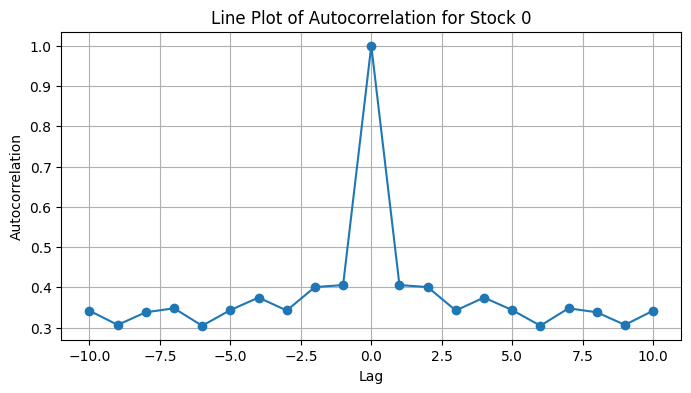

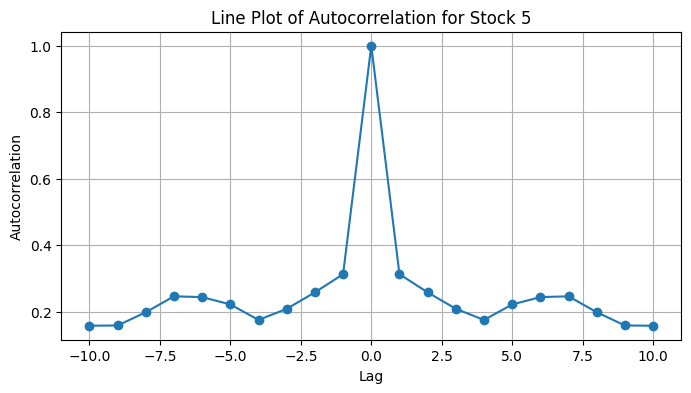

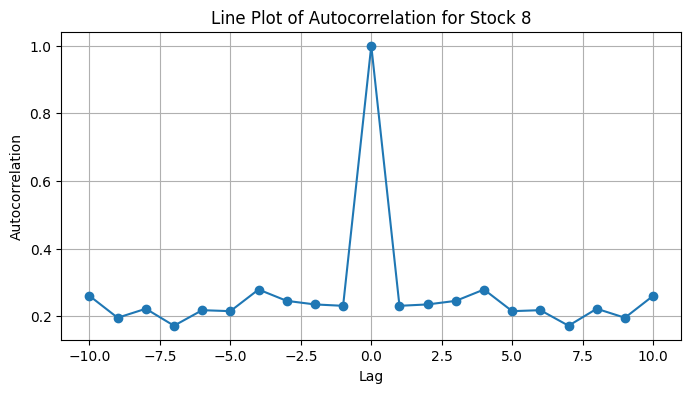

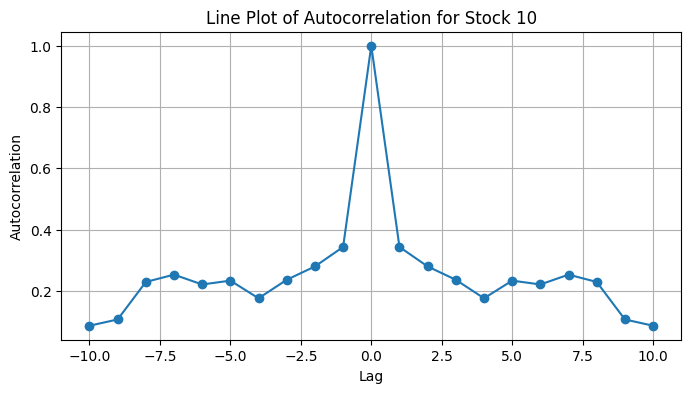

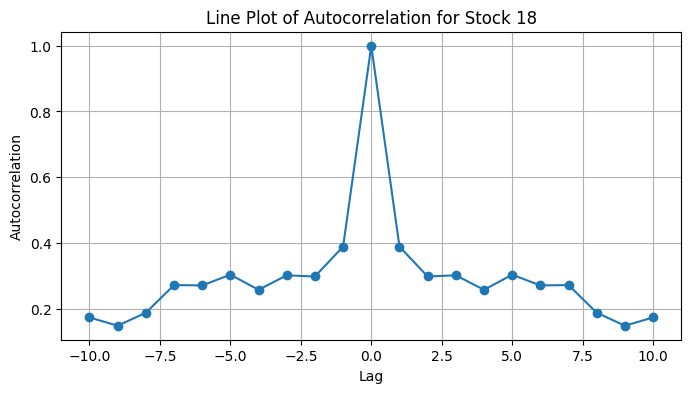

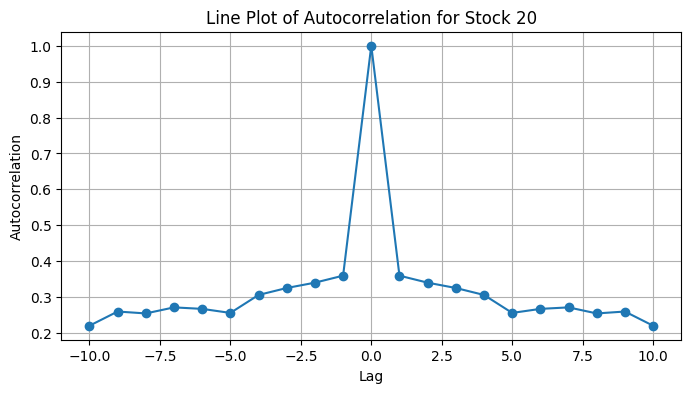

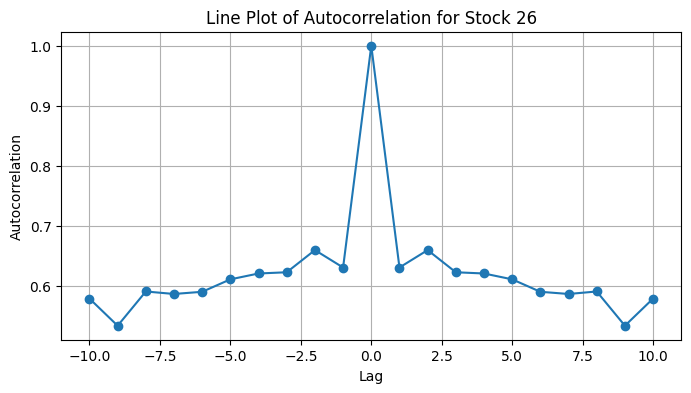

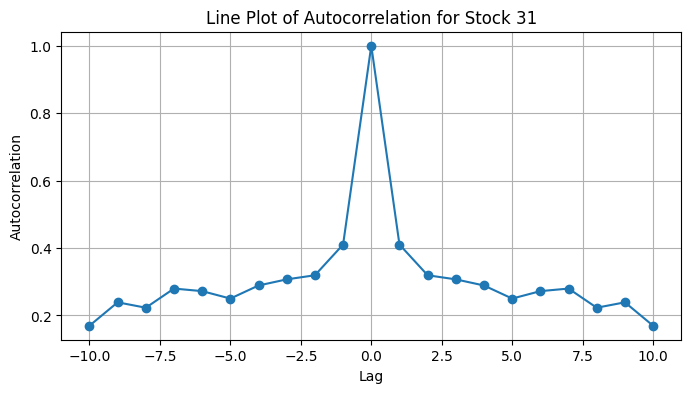

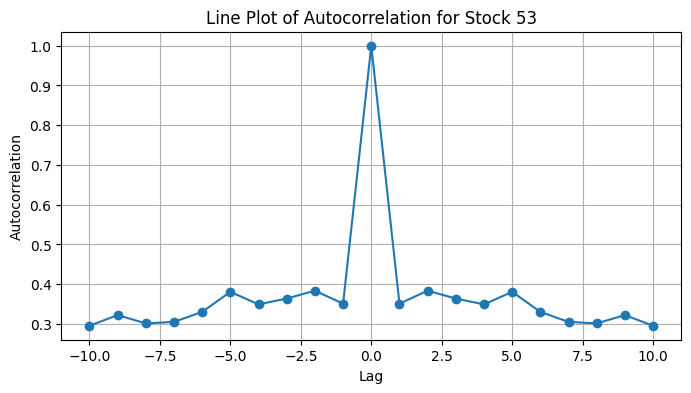

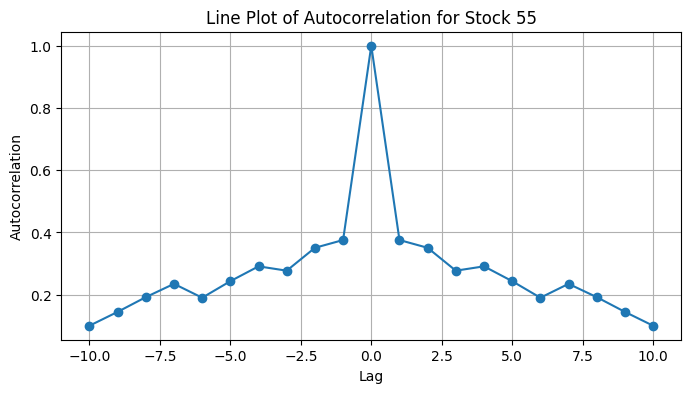

In [ ]:
#Q3 a) Cell 2
stock_ids = [0,5,8,10,18,20,26,31,53,55]#Generated from the result in Q3a Cell 3

# Create separate line plots for each of the random stock IDs
for stock_id in stock_ids:
    selected_stock_data = autocorrelation_df[autocorrelation_df['stock_id'] == stock_id]
    lag_values = range(-10, 11)
    autocorrelation_values = selected_stock_data.iloc[:, 1:].values.ravel()

    plt.figure(figsize=(8, 4))
    plt.plot(lag_values, autocorrelation_values, marker='o', linestyle='-')
    plt.title(f'Line Plot of Autocorrelation for Stock {stock_id}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.show()

In [ ]:
#Q3 a) cell 3
reference_value = 0
results_table = pd.DataFrame(columns=['Stock', 'T-statistic', 'P-value', 'Significance'])
results = []

for index, row in autocorrelation_df.iterrows():
    stock_id = row['stock_id']
    autocorrelation_values = row.iloc[1:]
    t_stat, p_value = ttest_1samp(autocorrelation_values, reference_value, nan_policy='omit')
    if p_value < 0.000005:
        significance = 'Significant'
    else:
        significance = 'Not Significant'
    results.append({'Stock': stock_id, 'T-statistic': t_stat, 'P-value': p_value, 'Significance': significance})

#Drawing a table
results_table = pd.DataFrame(results)
table_format = "html"
table = tabulate(results_table, headers='keys', tablefmt=table_format, showindex=False)
styled_table = f'<style>table, th, td {{border: 1px solid white; border-collapse: collapse;}}</style>{table}'
display(HTML(styled_table))


Stock,T-statistic,P-value,Significance
0,12.0298,1.30117e-10,Significant
1,4.11256,0.000540706,Not Significant
2,3.89693,0.000895165,Not Significant
3,4.4612,0.000239477,Not Significant
4,2.46488,0.0228832,Not Significant
5,6.63422,1.84665e-06,Significant
6,3.40937,0.00278063,Not Significant
7,4.4843,0.000226923,Not Significant
8,7.0591,7.61163e-07,Significant
9,4.05267,0.000621996,Not Significant


<h1>Q3 b)</h1>

The distance function that I'm using to measure the distance between 2 stocks is the absolute value of the difference of the newly calculated metrix 'performance'. This distance function should ideally point out those stocks that are similar (with less dsitance) and those that are dissimilar (with more distance). <br>

<b> OBSERVATION: </b>There are a few stock pairs that show an unusually high correlation with very less distance between them. The output of Q3b Cell 3 shows these pairs.
<br><br>
Q3b Cell 1 contains the calculation of distances between any 2 stocks. First I converted the requried columns into a pivoted table where columns represent the stocks and rows have the index days. This means that every cell in the pivoted table represents performance of a particular stock on a given day. <b>Important observation is that there are several null values in this pivoted table</b> which will be later in the notebook.
<br>
Q3b Cell 2 is used to approximate the threshold that can be used to find unusual similarity between 2 stocks
<br>

<h4>Conclusion</h4> There are a few stocks mentioned in Q3 b Cell 3 that show unusual similarity.  


In [ ]:
#Q3 b Cell 1
df_dummy = df_extra_features[['date_id','stock_id','performance']]
unique_stock_ids = df_dummy['stock_id'].unique()
n = len(unique_stock_ids)
stock_id_to_index = {stock_id: i for i, stock_id in enumerate(unique_stock_ids)}
unique_date_ids = df_dummy['date_id'].unique()
m = len(unique_date_ids)
result_array = np.empty((m, n, n))
result_array[:] = np.nan
pivot_table = df_dummy.pivot(index='date_id', columns='stock_id', values='performance')
for i, date_id in enumerate(unique_date_ids):
    date_data = pivot_table.loc[date_id].to_numpy()
    abs_diff = np.abs(date_data[:, np.newaxis] - date_data)
    result_array[i] = abs_diff
print(result_array)

[[[0.         0.00235828 0.0030623  ... 0.00449693 0.05160912        nan]
  [0.00235828 0.         0.00070402 ... 0.00213865 0.04925085        nan]
  [0.0030623  0.00070402 0.         ... 0.00143463 0.04854683        nan]
  ...
  [0.00449693 0.00213865 0.00143463 ... 0.         0.04711219        nan]
  [0.05160912 0.04925085 0.04854683 ... 0.04711219 0.                nan]
  [       nan        nan        nan ...        nan        nan        nan]]

 [[0.         0.00081435 0.00298531 ... 0.00340626 0.02890527        nan]
  [0.00081435 0.         0.00379967 ... 0.00422062 0.02809092        nan]
  [0.00298531 0.00379967 0.         ... 0.00042095 0.03189058        nan]
  ...
  [0.00340626 0.00422062 0.00042095 ... 0.         0.03231153        nan]
  [0.02890527 0.02809092 0.03189058 ... 0.03231153 0.                nan]
  [       nan        nan        nan ...        nan        nan        nan]]

 [[0.         0.00329917 0.00139566 ... 0.00486532 0.05013342        nan]
  [0.00329917 0.      

In [ ]:
#Q3 b cell 2
result_array = np.nan_to_num(result_array, nan=9999)
average_distances = np.nanmean(result_array, axis=0)

average_distances_min = np.nanmin(average_distances)
average_distances_max = np.nanmax(average_distances)
average_distances_mean = np.nanmean(average_distances)
average_distances_std = np.nanstd(average_distances)
average_distances_median = np.nanmedian(average_distances)
average_distances_25th_percentile = np.percentile(average_distances, 5)
average_distances_75th_percentile = np.percentile(average_distances, 75)

print("Minimum Average Distance:", average_distances_min)
print("Maximum Average Distance:", average_distances_max)
print("Mean Average Distance:", average_distances_mean)
print("Standard Deviation of Average Distance:", average_distances_std)
print("Median Average Distance:", average_distances_median)
print("5th Percentile of Average Distance:", average_distances_25th_percentile)
print("75th Percentile of Average Distance:", average_distances_75th_percentile)



Minimum Average Distance: 0.0
Maximum Average Distance: 6153.2356484546735
Mean Average Distance: 198.74518345164205
Standard Deviation of Average Distance: 843.6815355373778
Median Average Distance: 0.007679853568122286
5th Percentile of Average Distance: 0.003932837734807139
75th Percentile of Average Distance: 0.02705637565040017


In [ ]:
#Question 3b cell 3

threshold = 0.0031
consistent_pairs = np.argwhere(average_distances < threshold)
consistent_stock_pairs = [(unique_stock_ids[i], unique_stock_ids[j]) for i, j in consistent_pairs]

print("Unusually Consistent Stock Pairs:")
for stock_pair in consistent_stock_pairs:
    if(stock_pair[0] == stock_pair[1]):
      continue
    print(f"{stock_pair[0]} and {stock_pair[1]}")

Unusually Consistent Stock Pairs:
13 and 23
13 and 27
13 and 92
23 and 13
23 and 27
27 and 13
27 and 23
27 and 92
92 and 13
92 and 27


<h1>Question 3 c</h1>

The consensus record for each stock used is the mean of the columns 'last_imbalance', 'trajectory', 'average_size' as these columns are used to compute the 'performance' metric.

<br>
I can see <b>2 considerably big clusters</b> out of the 3 that I got.
The cluster number is chosen using the elbow method for optimal accuracy of the clusters. <br>
The clusters are visually very coherent as there are no overlapping colors and distinct clusters can be seen of each cluster id

In [ ]:
df_extra_features.columns

Index(['date_id', 'stock_id', 'last_imbalance', 'average_size', 'min', 'max',
       'trajectory', 'performance'],
      dtype='object')

<ipython-input-135-2131d5e06852>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[X.columns] = scaler.fit_transform(X)


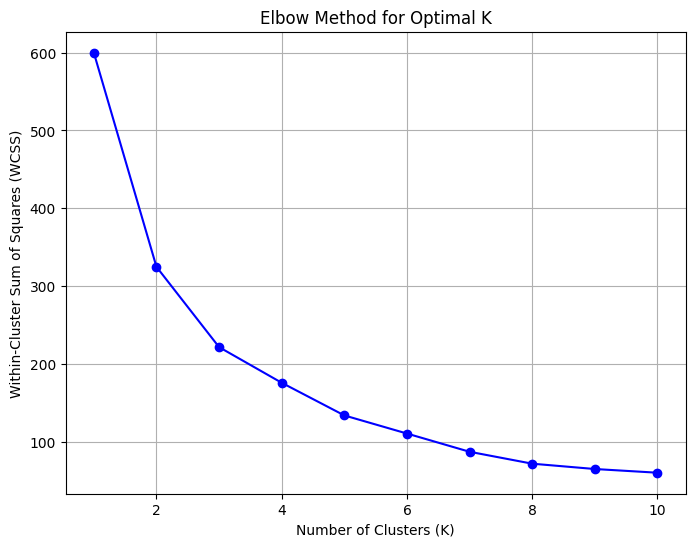

In [ ]:
#Q3c Cell 1

df_3c = df_extra_features[['stock_id','last_imbalance','trajectory','average_size']]
grouped = df_3c.groupby('stock_id')[['last_imbalance', 'trajectory', 'average_size']].mean().reset_index()
X = grouped[['last_imbalance', 'trajectory', 'average_size']]
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X)

# Define a range of values for K
k_values = range(1, 11)  # You can adjust this range based on your dataset

# Initialize an empty list to store the WCSS values
wcss = []

# Calculate WCSS for each K
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)  # Explicitly set n_init to suppress the warning
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values with consecutive integers on the x-axis
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(k_values) + 1), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()

In [ ]:
ideal_k = 3
kmeans = KMeans(n_clusters=ideal_k, random_state=0)
grouped['cluster'] = kmeans.fit_predict(X)

# Count the number of stocks in each cluster
cluster_counts = grouped['cluster'].value_counts()

# Print the number of stocks in each cluster
print("Cluster counts:")
print(cluster_counts)

Cluster counts:
0    174
2     20
1      6
Name: cluster, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


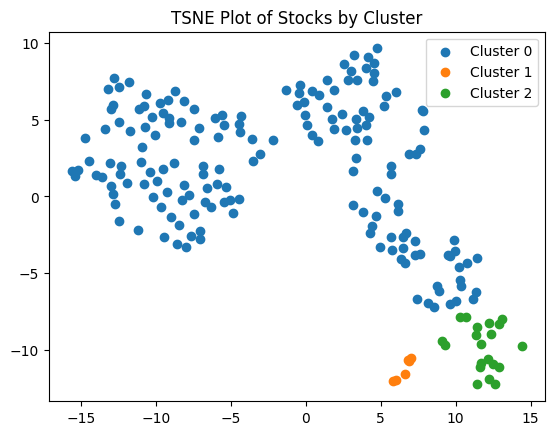

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

for cluster_id in range(ideal_k):
    cluster_mask = grouped['cluster'] == cluster_id
    plt.scatter(X_tsne[cluster_mask, 0], X_tsne[cluster_mask, 1], label=f'Cluster {cluster_id}')

plt.title('TSNE Plot of Stocks by Cluster')
plt.legend()
plt.show()

#### Q4: Closing trajectory of stocks on each day highly correlated, 25 pts
- a. Make three plots, 10 pts
- b. permutation test for statistical confidence, p-value, 15 pts


<h1>Q4</h1>

I think that the stocks are random and don't follow significant correlation. There are many ways to infer this. I have majorly focused on using the 'performance' metric that I have calculated.

<b><h4>Grarph a)</h4></b> Heatmap of correlation values of stocks based on 'performance'

My assumption behind making this graph is that if two graphs have similar trends of performance values then they will show a high correlation value. If the different stocks are random, then they correlation values will be very less. Refer Q4a Cell Graph A
<br><b>Observation:</b>
As observed from the heat map, the correlation values as very less and hence the stocks seem to be random from the first graph


<b><h4>Graph b)</h4></b> Following cells are used to do preprocessing in graph B. <b>Please refer only Cell 4a graph b) for the final plot</b> <br>
Intuition behind Graph B: I wanna see if volatility of different stocks affect the correlation of 2 stocks. For example if 2 stocks are volatile, do they show similar trend or if 2 stock are less volatile, do they show similar trend and so on.
<br> For this reason, I have clustered the stocks based based on the volatility (standard deviation) of the 'performance'. The cells Q4a cell1-4 show the necessary preprocessing required to generate this graph.<br>
<b>Observation:</b>
From the 3 different plots, it is observed that the deviation on each point of the fitted line is considerably big implying that the stocks with similar volatility don't necessarily follow the same trend

<b><h4>Graph c)</h4></b>
From the graph, for better oberservability, I have used any 100 stocks at random. The dendogram graph is calculated based on the heirarchical clustering of performance values and metric used is euclidean distance. Refer Q4a Cell Graph C<br>
<b>Observation:</b>
There seems to be no coherence between stocks of the same clusters. This shows that the performance of different stocks isn't following any trend as such.


<h3>Conclusion:</h3>
From the graphs and their observtions, I think that the stocks don't follow a trend in general and the fluctuations might be because of supply and demand cause distinct fluctuations on individual stocks each day.

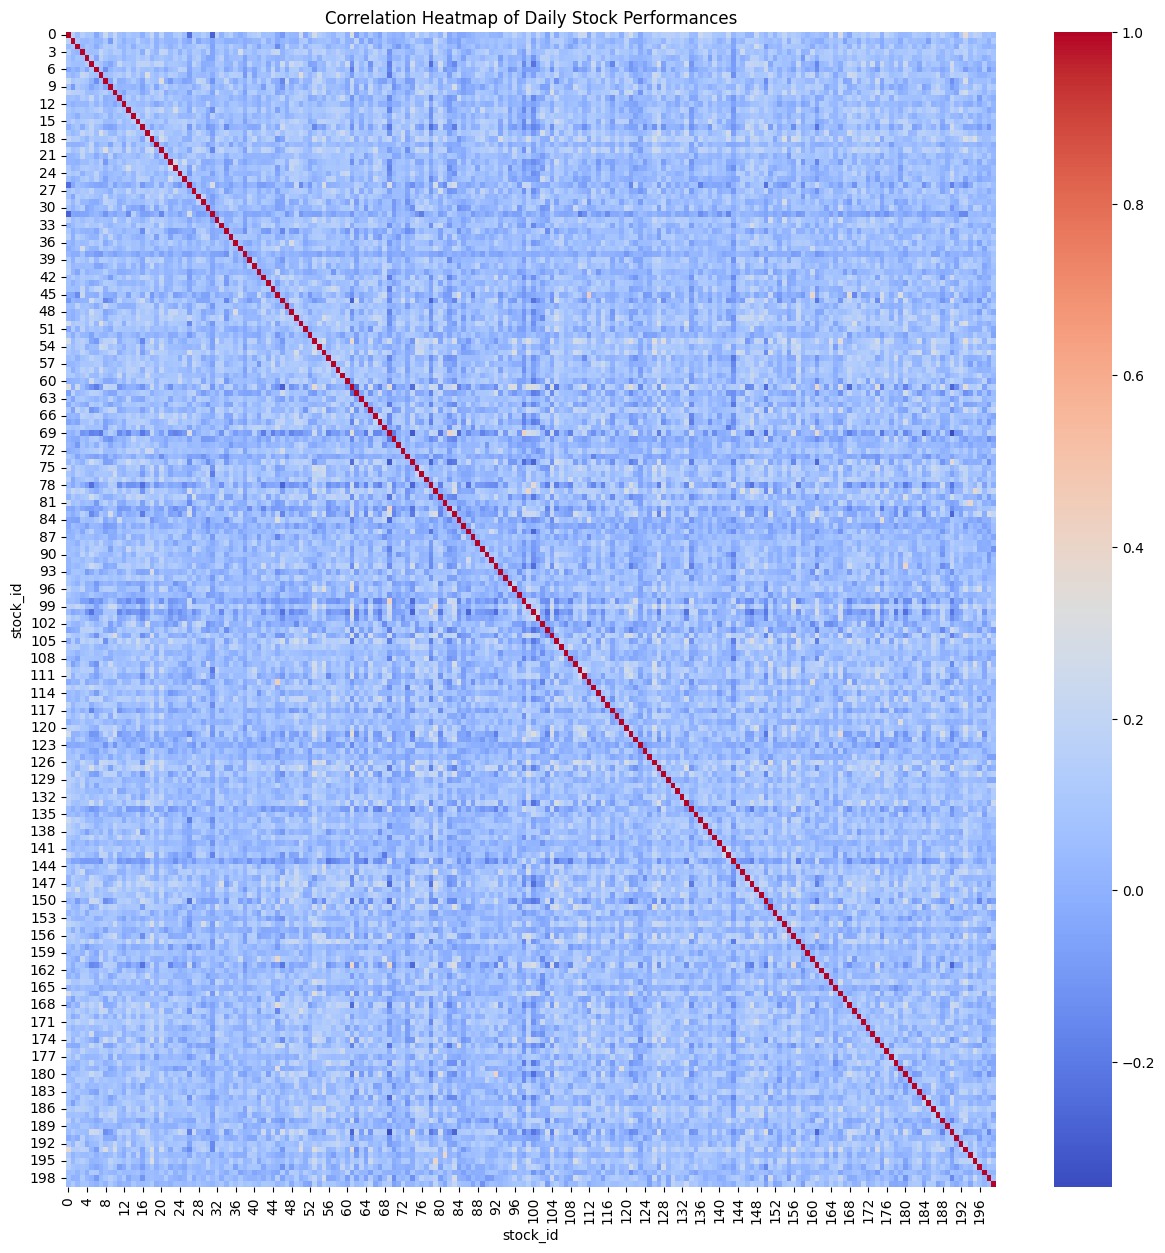

In [ ]:
#Q4a Graph A
pivot_df = df_extra_features[['date_id','stock_id','performance']].pivot(index='date_id', columns='stock_id', values='performance')

# 1. Correlation Heatmap
correlation_matrix = pivot_df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Heatmap of Daily Stock Performances')
plt.show()

In [ ]:
#Q4 a cell 1
#Finding null values
pivot_table = df_dummy.pivot(index='date_id', columns='stock_id', values='performance')
print(pivot_table.isna().sum().to_string())

stock_id
0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       1
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
35       0
36       0
37       0
38       0
39       0
40       0
41       0
42       0
43       0
44       0
45       0
46       0
47       0
48       0
49       0
50       0
51       0
52       0
53       0
54       0
55       0
56       0
57       0
58       0
59       0
60       0
61       0
62       0
63       0
64       0
65       0
66       0
67       0
68       0
69      37
70       0
71       0
72       0
73       1
74       0
75       0
76       0
77       0
78       4
79     181
80       0
81       0
82       0
83       0
84       0
85       0
86       0
87       0
88       0
89       0
9

In [ ]:
#Question 4a cell 2
#Dealing with null values
column_means = pivot_table.mean()
pivot_table = pivot_table.fillna(column_means)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

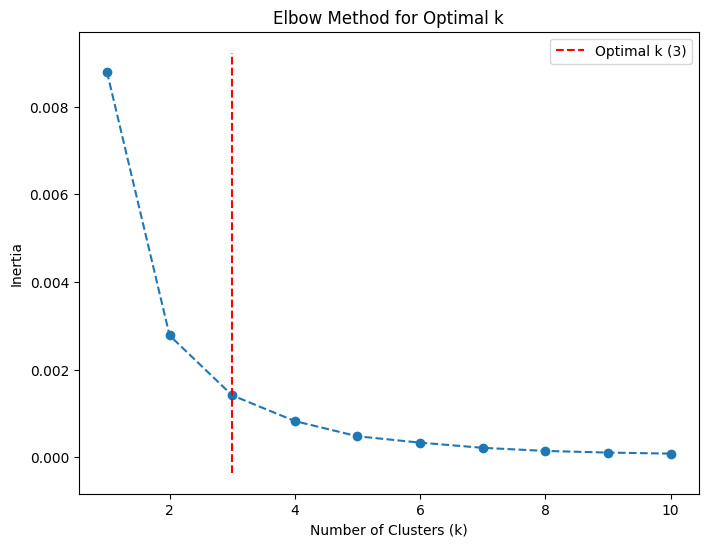

In [ ]:
# Question 4a cell 3
#Applying elbow method to find the best number of clusters
from kneed import KneeLocator

std_deviation = pivot_table.std()
std_deviation_array = std_deviation.values.reshape(-1, 1)

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(std_deviation_array)
    inertia.append(kmeans.inertia_)

kneedle = KneeLocator(range(1, 11), inertia, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

# Plot the inertia values and the knee point
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label=f'Optimal k ({optimal_k})')
plt.legend()
plt.show()

In [ ]:
#Question 4a cell 4
#Editing previous dataframe to incorporate cluster_ids
performance_df = df_extra_features[['date_id','stock_id','performance']].copy()
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
cluster_labels = kmeans.fit_predict(std_deviation_array)
my_dict = {i: cluster_labels[i] for i in range(200)}
stock_cluster_df = pd.DataFrame(list(my_dict.items()), columns=['stock_id', 'cluster_id'])
merged_df = performance_df.merge(stock_cluster_df, on='stock_id')
print(merged_df)

       date_id  stock_id  performance  cluster_id
0            0         0     0.236901           0
1            1         0     0.238480           0
2            2         0     0.239900           0
3            3         0     0.250827           0
4            4         0     0.245633           0
...        ...       ...          ...         ...
95227      476       102     0.234733           0
95228      477       102     0.239154           0
95229      478       102     0.232256           0
95230      479       102     0.239794           0
95231      480       102     0.239837           0

[95232 rows x 4 columns]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


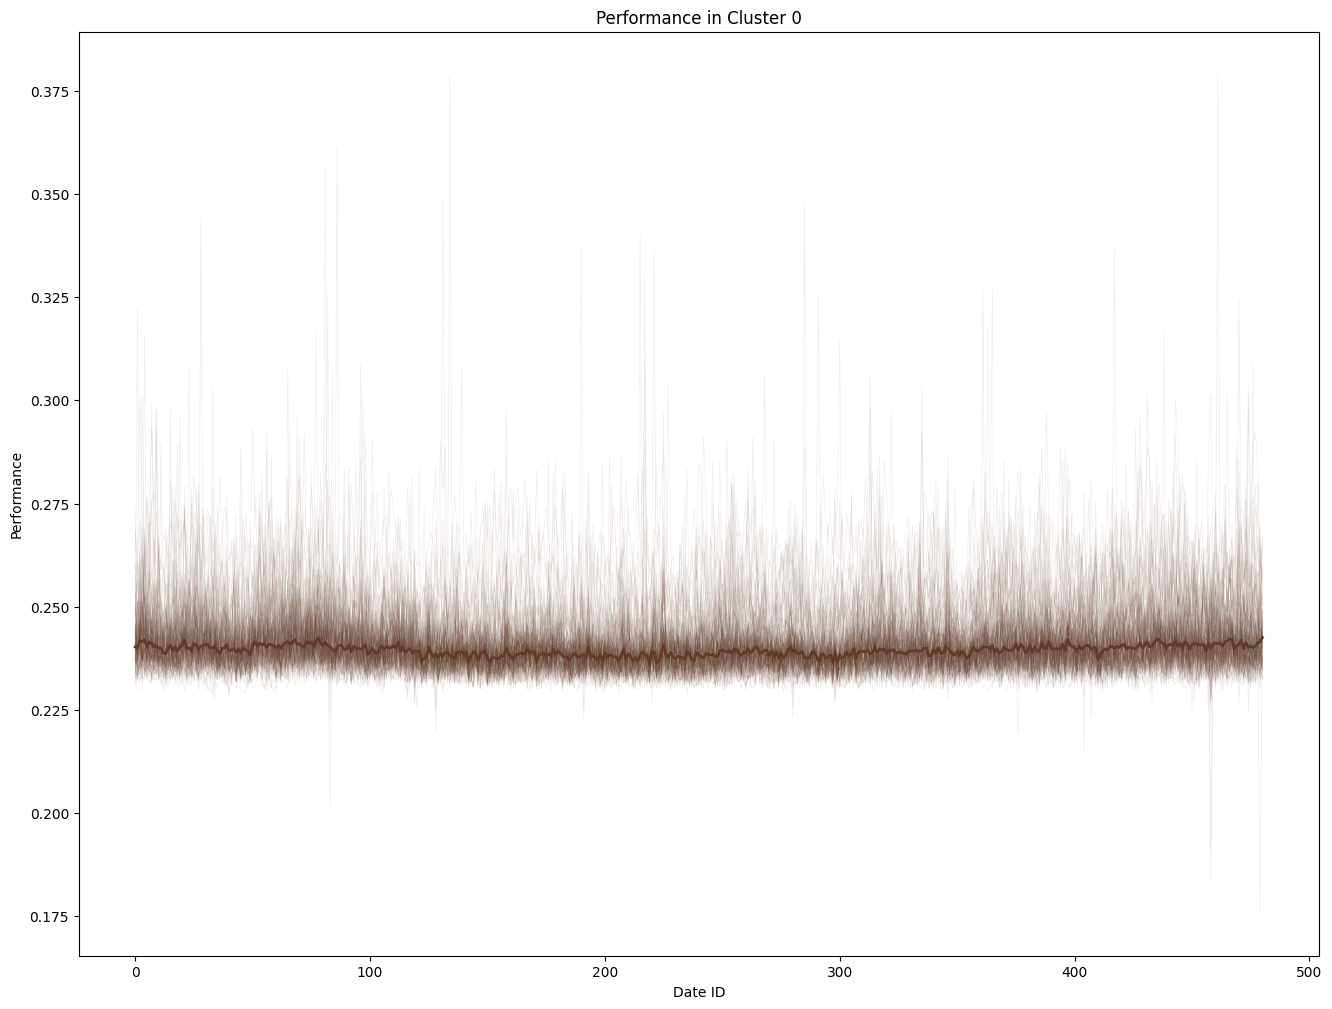

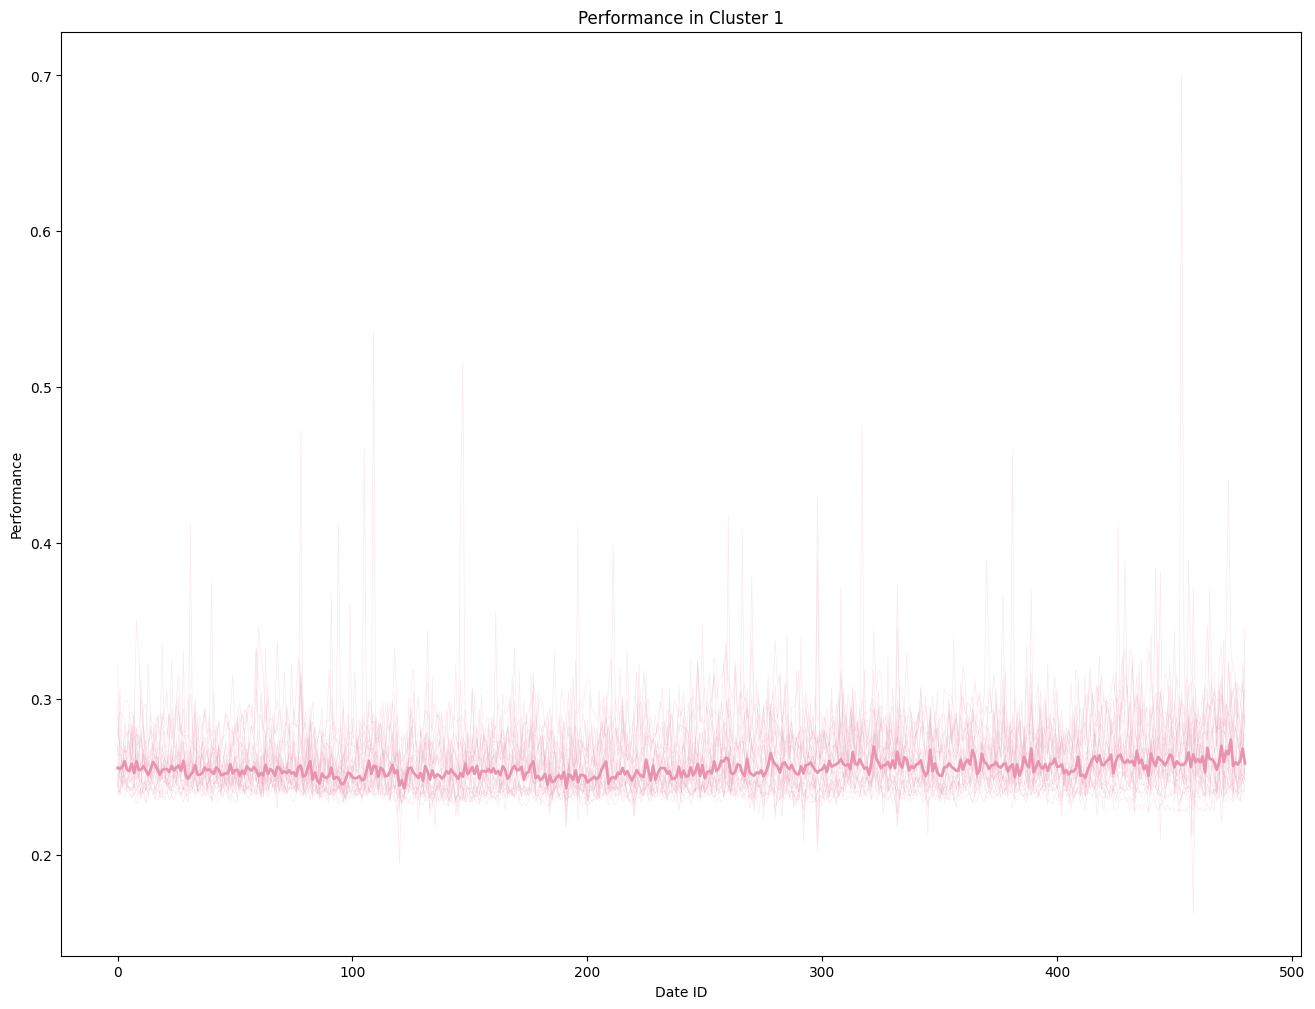

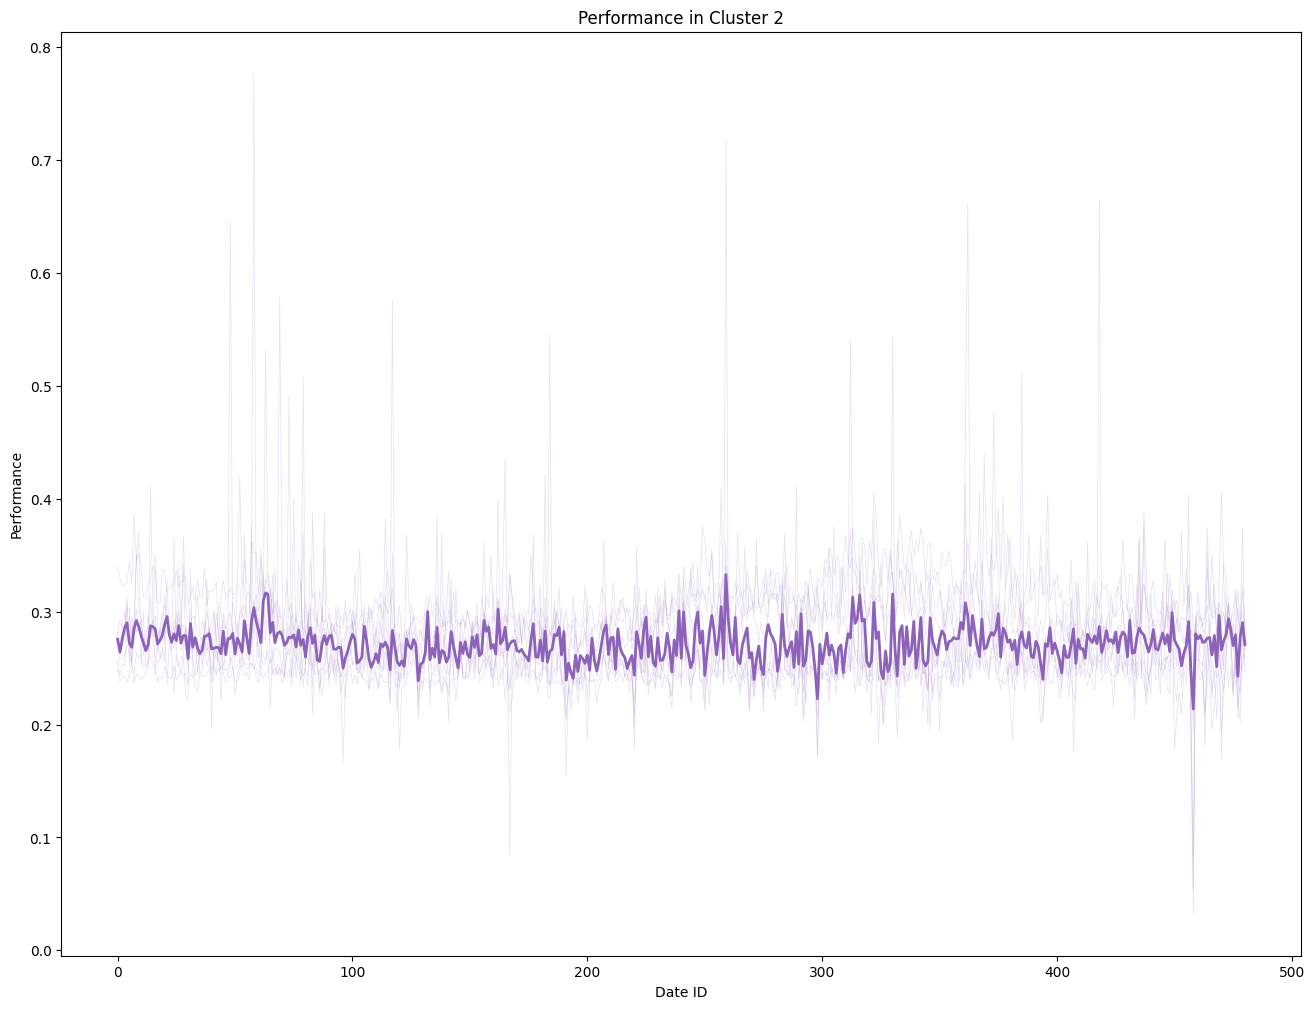

In [ ]:
# Question 4a Graph B)
cluster_values = range(3)
color_map = {}
random.seed(41)
for cluster_to_plot in cluster_values:
    color_map[cluster_to_plot] = (random.random(), random.random(), random.random())  # Generates a random color for each cluster

for cluster_to_plot in cluster_values:
    cluster_data = merged_df[merged_df['cluster_id'] == cluster_to_plot]
    plt.figure(figsize=(16, 12))
    cluster_color = color_map[cluster_to_plot]
    for stock_id, stock_data in cluster_data.groupby('stock_id'):
        if(cluster_to_plot==0):
          plt.plot(stock_data['date_id'], stock_data['performance'], alpha=0.09, color=cluster_color, label=f'Cluster {cluster_to_plot}', linewidth=0.5)
        else:
          plt.plot(stock_data['date_id'], stock_data['performance'], alpha=0.2, color=cluster_color, label=f'Cluster {cluster_to_plot}', linewidth=0.5)
    cluster_mean = cluster_data.groupby('date_id')['performance'].median().reset_index()
    plt.plot(cluster_mean['date_id'], cluster_mean['performance'], alpha=1, label=f'Cluster {cluster_to_plot}', color=cluster_color, linewidth=2)

    plt.title(f'Performance in Cluster {cluster_to_plot}')
    plt.xlabel('Date ID')
    plt.ylabel('Performance')
    plt.show()

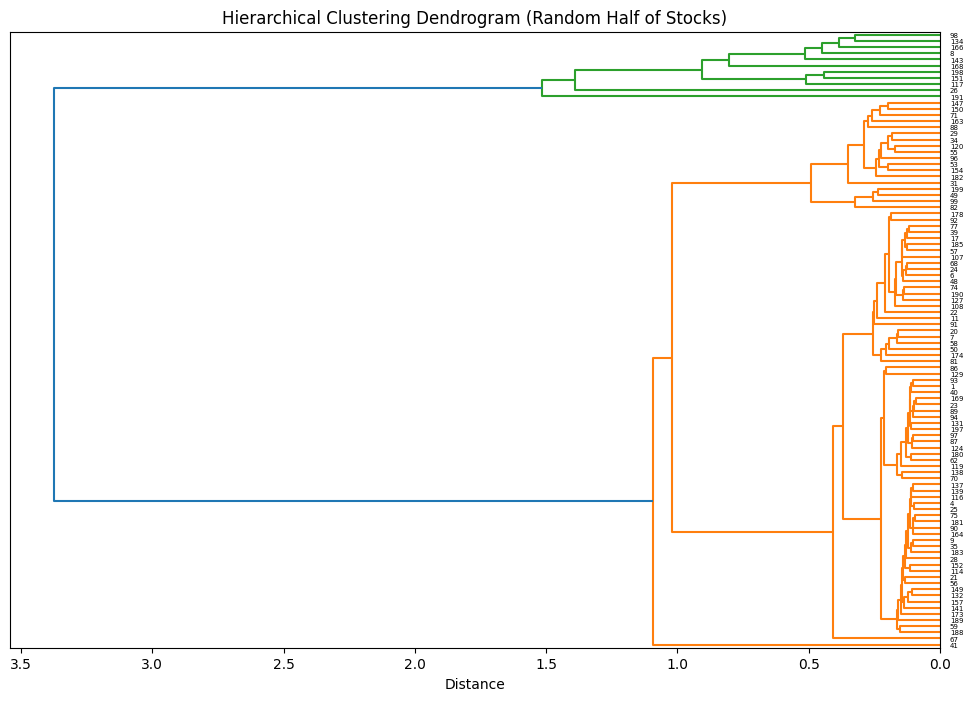

In [ ]:
#Question 4a Graph C)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

random.seed(42)
stock_ids = pivot_table.columns
random_stock_ids = random.sample(list(stock_ids), len(stock_ids) // 2)
filtered_pivot_df = pivot_table[random_stock_ids]
distance_matrix = pdist(filtered_pivot_df.T, metric = 'euclidean')
linkage_matrix = linkage(distance_matrix, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=filtered_pivot_df.columns, orientation='left', leaf_font_size=5)

plt.title('Hierarchical Clustering Dendrogram (Random Half of Stocks)')
plt.xlabel('Distance')
plt.show()

<h1>Q4 B</h1>

I have used the transposed pivot table to calculate the permutation test. The original pivot table contains stock_ids as columns and date_ids as rows. <br>
The p value is calulated for 20000 iterations. <br>
<h3> Observations:</h3>
<b>Null Hypothesis:</b> The stocks are uncorrelated, i.e., the stocks are essentially random<br>
<b>P value:</b> 0.5010
Since the p_value is not smaller than 0.05(significance level), we cannot reject the null hypothesis to be false.
<h3>Conclusion:</h3>
Stocks are random and don't show correlation.

In [ ]:
#Q4b Cell1
pivot_table = pivot_table.T
pivot_table

date_id,0,1,2,3,4,5,6,7,8,9,...,471,472,473,474,475,476,477,478,479,480
stock_id,,,,,,,,,,,,,,,,,,,,,
0,0.236901,0.238480,0.239900,0.250827,0.245633,0.250389,0.238570,0.242497,0.236947,0.240361,...,0.242616,0.246891,0.245942,0.248483,0.247574,0.248449,0.245053,0.246542,0.248724,0.250756
1,0.239260,0.239294,0.243199,0.236942,0.240079,0.239527,0.244173,0.241496,0.235744,0.242858,...,0.238465,0.243039,0.236783,0.239743,0.235674,0.241543,0.242335,0.241757,0.237950,0.244155
2,0.239964,0.235495,0.241295,0.237785,0.237234,0.232384,0.234104,0.245595,0.238295,0.238396,...,0.251074,0.238328,0.233262,0.238621,0.240454,0.235347,0.237440,0.242849,0.237118,0.243901
3,0.239184,0.242117,0.240333,0.240884,0.241951,0.235998,0.241830,0.243277,0.239330,0.240008,...,0.234087,0.234982,0.244684,0.240662,0.239598,0.235349,0.238233,0.242909,0.243813,0.247299
4,0.244248,0.239341,0.241073,0.237073,0.239009,0.240556,0.242287,0.240698,0.243636,0.237790,...,0.242059,0.237891,0.237884,0.237494,0.241649,0.242381,0.243721,0.241643,0.236320,0.245519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.246523,0.241024,0.243053,0.236956,0.242807,0.241090,0.251133,0.250950,0.240301,0.243451,...,0.240633,0.242229,0.245842,0.248268,0.246906,0.249442,0.255126,0.248259,0.243327,0.242169
196,0.245371,0.241782,0.246642,0.242053,0.248757,0.246506,0.241853,0.240772,0.240017,0.237226,...,0.235735,0.241421,0.233040,0.236296,0.240104,0.242110,0.240637,0.238899,0.243332,0.247383
197,0.241398,0.235074,0.244765,0.243504,0.243041,0.238819,0.235841,0.241627,0.241682,0.241034,...,0.241068,0.241914,0.238740,0.244285,0.235697,0.236147,0.235107,0.237893,0.242912,0.241438


In [ ]:
#Question4b Cell 2
def calculate_test_statistic(data):
    return np.mean(data, axis=0)

num_permutations = 20000
permuted_stats = []
for _ in range(num_permutations):
    column_names = pivot_table.columns
    indexes = pivot_table.index
    permute_columns = np.random.permutation(pivot_table.columns)
    permuted_df = pivot_table[permute_columns]
    permuted_df.columns = column_names
    permuted_df.index = indexes
    permuted_statistic = calculate_test_statistic(permuted_df)
    permuted_stats.append(permuted_statistic)

prev_stat = calculate_test_statistic(pivot_table)
prev_stat = np.array(prev_stat)

p_value = (np.sum(np.array(permuted_stats) >= prev_stat[:, np.newaxis].T)) / ((num_permutations)*len(pivot_table.columns))
print("P-Value:", p_value)
significance_level = 0.05

if p_value <= significance_level:
    print("The closing trajectory of stocks is not essentially random.")
else:
    print("The closing trajectory of stocks is essentially random.")

P-Value: 0.5010246361746362
The closing trajectory of stocks is essentially random.


#### Q5: Best prediction model, any approaches, 25 pts


Preprocessing steps:
<ul><li>Remove recrods with several null values
<li> Impute values of far_price and near_price with median and mean respectively
<li> Standard scaling for specifc columns in the data frame
<li> Use feature engineering to generate 2 new columns called 'imbalance_magnitude'(used to reduce the number of features to avoid over fitting of data) and 'wapratio'(Used this feature represent 2 important component for predicting the target).
</ul>

Models used:<ol>
<li> Linear Regression
<ul><li>Observation: Test MAE: 6.309208043202752 </ul>
<li> Linear Regression with L1 Regularization
<ul><li>Optimization used: Grid Search
<li>Observation: Test MAE: 6.312439951028701
</ul>
<li> Linear Regression with L2 Regularization
<ul><li>Optimization used: Grid Search
<li>Observation: Test MAE: 6.309136007902401
</ul>
<li> XGBoost Regressor
<ul>
<li>Observation: Mean Absolute Error on the test set: 6.314229587150241
</ul>
</ol>

<h3>Reasons</h3>
Possible result of the linear regression performing so much better might be due to over fitting. Since the number of features are a lot, the linear regression without regularization will have a tendency to overfit. This overfitting can be reduced by introducing a penalty term or a bias which I have done by using L1 and L2 regularization. This might decrease the training accuracy by it should generalize better than linear regression with these many features.<br>
Since the model tends to overfit, XGBoost is a great alternative to avoid overfitting as it uses the ensemble method of calculating the final result. Hence, I have used XGBoost Regressor to find this better fit which is not overfitted <br>
FAILED Attempts:
The RAM kept crashing when I tried to feed in the input data to models like LSTM, Polynomial Regression and HMM that might have given a better result than this.

In [ ]:
new_df = csv.copy()
new_df['imbalance_magnitude'] = new_df['imbalance_size'] * new_df['imbalance_buy_sell_flag']
new_df['wapratio'] = new_df['wap'] / new_df['reference_price']

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error

X = new_df[['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_magnitude', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap','wapratio']]
y = new_df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
mae_scores = -cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
average_mae = mae_scores.mean()

print("Average MAE:", average_mae)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", test_mae)

Average MAE: 6.323458329486736
Test MAE: 6.309208043202752


In [ ]:
alpha_values = [0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = {'alpha': alpha_values}
model = Lasso()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(X_train, y_train)
best_alpha_lasso = grid_search.best_params_['alpha']
print("Best alpha:", best_alpha_lasso)

Best alpha: 0.01


In [ ]:
model = Lasso(alpha=best_alpha_lasso)
mae_scores = -cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
average_mae = mae_scores.mean()
print("Average MAE using 5-fold cross-validation:", average_mae)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
print("Test MAE:", test_mae)

Average MAE using 5-fold cross-validation: 6.326529568501316
Test MAE: 6.312408806886892


In [ ]:
alpha_values = [0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = {'alpha': alpha_values}
model = Ridge()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(X_train, y_train)
best_alpha_ridge = grid_search.best_params_['alpha']
print("Best alpha:", best_alpha_ridge)

Best alpha: 0.01


In [ ]:
model = Ridge(best_alpha_ridge)
mae_scores = -cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
average_mae = mae_scores.mean()
print("Average MAE using 5-fold cross-validation:", average_mae)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
print("Test MAE:", test_mae)

Average MAE using 5-fold cross-validation: 6.323458333279629
Test MAE: 6.3092080466965506


In [ ]:
import xgboost as xgb
model = xgb.XGBRegressor(
    objective="reg:squarederror",  # Objective for regression
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage to prevent overfitting
    max_depth=3                   # Maximum tree depth
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mae_scores = -cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv=5)
average_mae = mae_scores.mean()

print("Mean Absolute Error for each fold:", mae_scores)
print("Average Mean Absolute Error:", average_mae)
model.fit(X_train, y_train)
Ypred = model.predict(X_test)
mae_test = mean_absolute_error(y_test, Ypred)
print("Mean Absolute Error on the test set:", mae_test)

Mean Absolute Error for each fold: [6.33621382 6.33552397 6.3186583  6.33039549 6.31921763]
Average Mean Absolute Error: 6.328001842833557
Mean Absolute Error on the test set: 6.314229587150241


#### Q6: submit model on Kaggle, 0 pts
Public Score: 5.5935 \
Private Score: 5.5935 \
Kaggle profile link: https://www.kaggle.com/aayushnshah \
Screenshot(s): 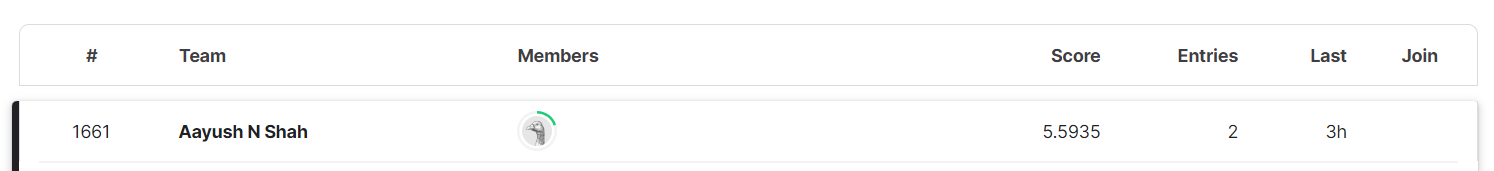

In [ ]:
!pip install nbconvert
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!jupyter nbconvert --to pdf --output cse519_hw3_shah_aayushnilesh_115647307.pdf cse519_hw3_shah_aayushnilesh_115647307.ipynb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibu

In [ ]:
%pwd

'/content/drive/MyDrive/CSE519/hw3'